In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score, accuracy_score
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# Установка seed для воспроизводимости результатов
np.random.seed(42)

# 1. ГЕНЕРАЦИЯ ДАННЫХ
print("\nГЕНЕРАЦИЯ ДАННЫХ")
print("-" * 50)

# Параметры распределений
centers = np.array([[3, 3], [9, 2], [9, 6]])
covariances = [
    np.array([[1.5, 0], [0, 1.5]]),  # Для первого кластера
    np.array([[1, 0], [0, 1]]),      # Для второго кластера  
    np.array([[1, 0], [0, 1]])       # Для третьего кластера
]

n_samples = 200  # Количество элементов в каждой выборке

# Генерация данных
data = []
true_labels = []
for i, (center, cov) in enumerate(zip(centers, covariances)):
    cluster_data = np.random.multivariate_normal(center, cov, n_samples)
    data.append(cluster_data)
    true_labels.extend([i] * n_samples)

# Объединение всех данных
X = np.vstack(data)
y_true = np.array(true_labels)

print(f"Размерность данных: {X.shape}")
print(f"Количество кластеров: {len(centers)}")
print(f"Количество элементов в каждом кластере: {n_samples}")
print(f"Центры кластеров:\n{centers}")

# 2. КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-СРЕДНИХ
print("\n1. КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-СРЕДНИХ")
print("-" * 50)

# Применение алгоритма k-средних
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X)

# Центры кластеров, найденные алгоритмом
found_centers = kmeans.cluster_centers_

# Функция для переназначения меток в правильном порядке
def remap_labels(true_centers, predicted_centers, predicted_labels):
    """
    Переназначает метки кластеров так, чтобы они соответствовали истинным центрам
    """
    # Вычисляем матрицу расстояний между истинными и предсказанными центрами
    distance_matrix = np.zeros((len(true_centers), len(predicted_centers)))
    for i, true_center in enumerate(true_centers):
        for j, pred_center in enumerate(predicted_centers):
            distance_matrix[i, j] = np.linalg.norm(true_center - pred_center)
    
    # Находим оптимальное сопоставление (венгерский алгоритм)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Создаем маппинг: старые метки -> новые метки
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(col_ind)}
    
    # Применяем маппинг к предсказанным меткам
    remapped_labels = np.array([label_mapping[label] for label in predicted_labels])
    
    # Переупорядочиваем центры в соответствии с новыми метками
    remapped_centers = predicted_centers[col_ind]
    
    return remapped_labels, remapped_centers, col_ind

# Переназначаем метки
y_kmeans_remapped, found_centers_remapped, mapping = remap_labels(centers, found_centers, y_kmeans)

print("Результаты кластеризации:")
print("Центры кластеров (истинные):")
for i, center in enumerate(centers):
    print(f" Кластер {i+1}: [{center[0]:.2f}, {center[1]:.2f}]")

print("Центры кластеров (найденные алгоритмом):")
for i, center in enumerate(found_centers_remapped):
    print(f" Кластер {i+1}: [{center[0]:.2f}, {center[1]:.2f}]")


# Вычисление среднеквадратичной ошибки с переназначенными метками
mse = np.mean((X - found_centers_remapped[y_kmeans_remapped])**2)
print(f"Среднеквадратичная ошибка: {mse:.4f}")

# Дополнительно: Silhouette score для оценки качества кластеризации
silhouette = silhouette_score(X, y_kmeans_remapped)
print(f"Silhouette score: {silhouette:.4f}")



ГЕНЕРАЦИЯ ДАННЫХ
--------------------------------------------------
Размерность данных: (600, 2)
Количество кластеров: 3
Количество элементов в каждом кластере: 200
Центры кластеров:
[[3 3]
 [9 2]
 [9 6]]

1. КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-СРЕДНИХ
--------------------------------------------------
Результаты кластеризации:
Центры кластеров (истинные):
 Кластер 1: [3.00, 3.00]
 Кластер 2: [9.00, 2.00]
 Кластер 3: [9.00, 6.00]
Центры кластеров (найденные алгоритмом):
 Кластер 1: [2.98, 3.07]
 Кластер 2: [8.91, 1.99]
 Кластер 3: [9.21, 6.12]
Среднеквадратичная ошибка: 1.0948
Silhouette score: 0.5994


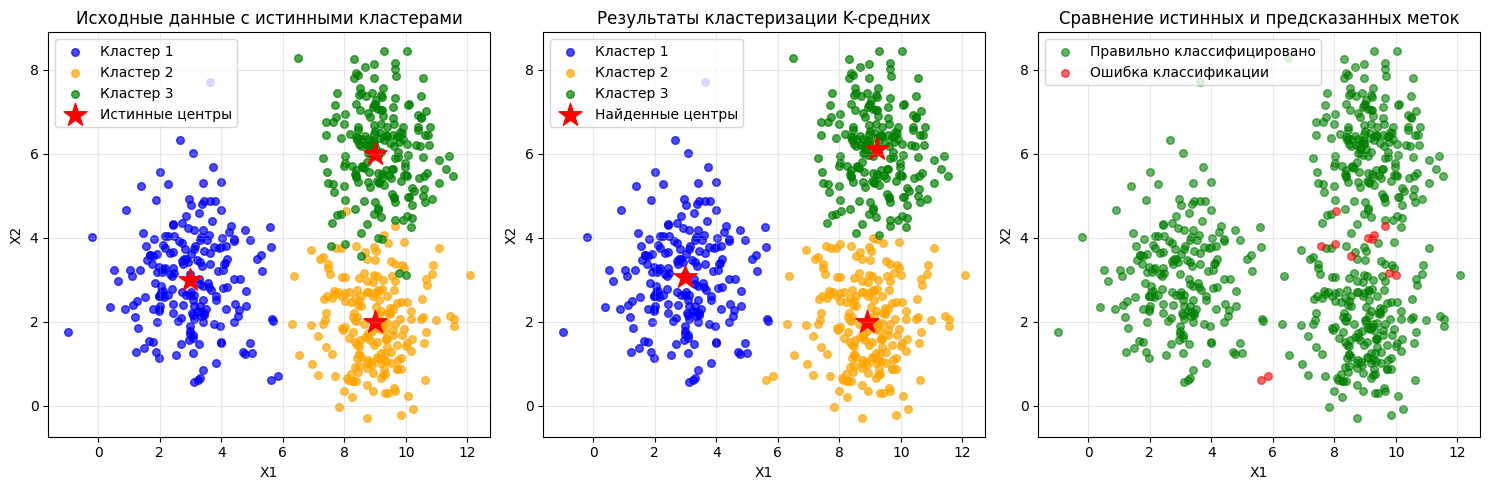

In [12]:
plt.figure(figsize=(15, 5))

# Исходные данные с истинными метками
plt.subplot(1, 3, 1)
colors = ['blue', 'orange', 'green']
for i in range(len(centers)):
    plt.scatter(X[y_true == i, 0], X[y_true == i, 1], 
                color=colors[i], label=f'Кластер {i+1}', alpha=0.7, s=30)
plt.scatter(centers[:, 0], centers[:, 1], marker='*', 
           s=300, c='red', label='Истинные центры')
plt.title('Исходные данные с истинными кластерами')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Результаты кластеризации k-средних (с переназначенными метками)
plt.subplot(1, 3, 2)
for i in range(len(centers)):
    plt.scatter(X[y_kmeans_remapped == i, 0], X[y_kmeans_remapped == i, 1], 
                color=colors[i], label=f'Кластер {i+1}', alpha=0.7, s=30)
plt.scatter(found_centers_remapped[:, 0], found_centers_remapped[:, 1], marker='*', 
           s=300, c='red', label='Найденные центры')
plt.title('Результаты кластеризации K-средних')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Сравнение истинных и предсказанных меток
plt.subplot(1, 3, 3)
correct = y_true == y_kmeans_remapped
incorrect = ~correct
plt.scatter(X[correct, 0], X[correct, 1], 
           c='green', label='Правильно классифицировано', alpha=0.6, s=30)
plt.scatter(X[incorrect, 0], X[incorrect, 1], 
           c='red', label='Ошибка классификации', alpha=0.6, s=30)
plt.title('Сравнение истинных и предсказанных меток')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# 2. КЛАССИФИКАЦИЯ
print("\n2. КЛАССИФИКАЦИЯ")
print("-" * 50)

# Используем ПЕРЕНАЗНАЧЕННЫЕ метки от k-средних как целевые переменные для классификации
y_classification = y_kmeans_remapped

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_classification, test_size=0.3, random_state=42, stratify=y_classification
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

# 2.1 Метод k ближайших соседей с разными k
print("\n2.1 МЕТОД K БЛИЖАЙШИХ СОСЕДЕЙ (С РАЗНЫМИ K)")
print("-" * 50)

knn_results = []
k_values = [1, 3, 5, 7, 9, 11, 15, 20]  # Разные значения k для анализа

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    cm_knn = confusion_matrix(y_test, y_pred_knn)
    report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
    knn_results.append({
        'k': k,
        'Точность': acc_knn,
        'Матрица ошибок': cm_knn,
        'Precision (weighted)': report_knn['weighted avg']['precision'],
        'Recall (weighted)': report_knn['weighted avg']['recall'],
        'F1-score (weighted)': report_knn['weighted avg']['f1-score']
    })
    print(f"\nkNN с k={k}:")
    print(f"Точность: {acc_knn:.4f}")
    print("Матрица ошибок:")
    print(cm_knn)



2. КЛАССИФИКАЦИЯ
--------------------------------------------------
Размер обучающей выборки: 420
Размер тестовой выборки: 180

2.1 МЕТОД K БЛИЖАЙШИХ СОСЕДЕЙ (С РАЗНЫМИ K)
--------------------------------------------------

kNN с k=1:
Точность: 0.9778
Матрица ошибок:
[[59  0  0]
 [ 1 60  1]
 [ 0  2 57]]

kNN с k=3:
Точность: 0.9833
Матрица ошибок:
[[59  0  0]
 [ 1 60  1]
 [ 0  1 58]]

kNN с k=5:
Точность: 0.9833
Матрица ошибок:
[[59  0  0]
 [ 1 60  1]
 [ 0  1 58]]

kNN с k=7:
Точность: 0.9889
Матрица ошибок:
[[59  0  0]
 [ 1 61  0]
 [ 0  1 58]]

kNN с k=9:
Точность: 0.9889
Матрица ошибок:
[[59  0  0]
 [ 1 60  1]
 [ 0  0 59]]

kNN с k=11:
Точность: 0.9889
Матрица ошибок:
[[59  0  0]
 [ 1 61  0]
 [ 0  1 58]]

kNN с k=15:
Точность: 0.9944
Матрица ошибок:
[[59  0  0]
 [ 1 61  0]
 [ 0  0 59]]

kNN с k=20:
Точность: 0.9889
Матрица ошибок:
[[59  0  0]
 [ 1 60  1]
 [ 0  0 59]]


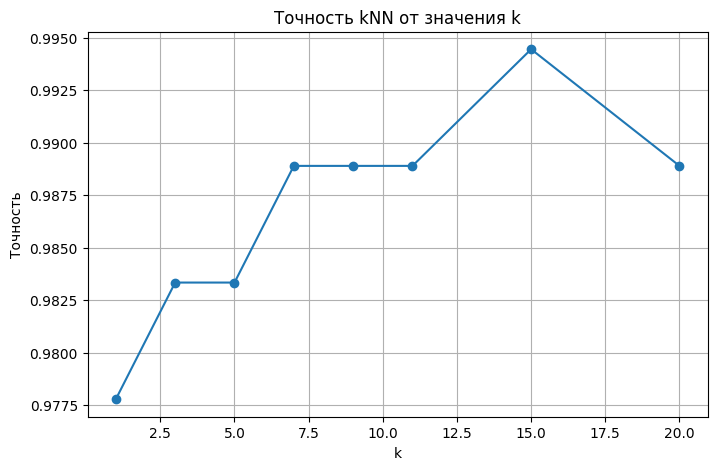

In [18]:
import pandas as pd

# Создаем DataFrame из результатов k-NN
knn_df = pd.DataFrame(knn_results)

# Дополнительный график: Точность kNN от k
plt.figure(figsize=(8, 5))
plt.plot(knn_df['k'], knn_df['Точность'], marker='o', linestyle='-')
plt.title('Точность kNN от значения k')
plt.xlabel('k')
plt.ylabel('Точность')
plt.grid(True)
plt.show()


In [19]:
# 2.2 Наивный байесовский классификатор
print("\n2.2 НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР")
print("-" * 30)

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Оценка точности
acc_nb = accuracy_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)

print(f"Точность: {acc_nb:.4f}")
print("Матрица ошибок:")
print(cm_nb)

# ТАБЛИЦЫ РЕЗУЛЬТАТОВ
print("\nТАБЛИЦЫ РЕЗУЛЬТАТОВ")
print("-" * 50)

# Таблица для kNN
knn_df = pd.DataFrame(knn_results)
print("\nРезультаты kNN с разными k:")
print(knn_df.to_string(index=False))

# Результаты NB
nb_result = {
    'Метод': 'Наивный Байес',
    'Точность': acc_nb,
    'Precision (weighted)': report_nb['weighted avg']['precision'],
    'Recall (weighted)': report_nb['weighted avg']['recall'],
    'F1-score (weighted)': report_nb['weighted avg']['f1-score']
}
print("\nРезультаты Наивного Байеса:")
print(pd.DataFrame([nb_result]).to_string(index=False))



2.2 НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР
------------------------------
Точность: 0.9944
Матрица ошибок:
[[59  0  0]
 [ 1 61  0]
 [ 0  0 59]]

ТАБЛИЦЫ РЕЗУЛЬТАТОВ
--------------------------------------------------

Результаты kNN с разными k:
 k  Точность                       Матрица ошибок  Precision (weighted)  Recall (weighted)  F1-score (weighted)
 1  0.977778 [[59, 0, 0], [1, 60, 1], [0, 2, 57]]              0.977775           0.977778             0.977730
 3  0.983333 [[59, 0, 0], [1, 60, 1], [0, 1, 58]]              0.983335           0.983333             0.983289
 5  0.983333 [[59, 0, 0], [1, 60, 1], [0, 1, 58]]              0.983335           0.983333             0.983289
 7  0.988889 [[59, 0, 0], [1, 61, 0], [0, 1, 58]]              0.988981           0.988889             0.988888
 9  0.988889 [[59, 0, 0], [1, 60, 1], [0, 0, 59]]              0.989074           0.988889             0.988844
11  0.988889 [[59, 0, 0], [1, 61, 0], [0, 1, 58]]              0.988981           0.988

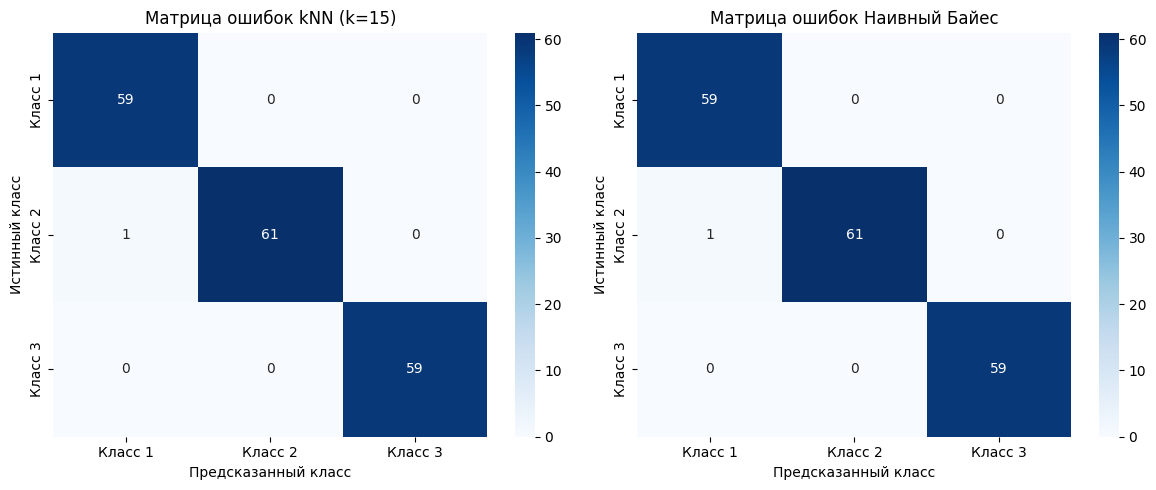

In [20]:
# Визуализация матриц ошибок (для лучшего kNN и NB)
best_knn_idx = knn_df['Точность'].argmax()
best_knn_cm = knn_results[best_knn_idx]['Матрица ошибок']
best_k = knn_results[best_knn_idx]['k']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(best_knn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Класс {i+1}' for i in range(3)],
            yticklabels=[f'Класс {i+1}' for i in range(3)])
plt.title(f'Матрица ошибок kNN (k={best_k})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Класс {i+1}' for i in range(3)],
            yticklabels=[f'Класс {i+1}' for i in range(3)])
plt.title('Матрица ошибок Наивный Байес')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.tight_layout()
plt.show()
